# TC 5033
## Deep Learning
## Transfer Learning
<br>
Professor: José Antonio Cantoral Ceballos

Team 30
* Alejandro Hahn Gallegos - A01561774
* Giovanni Andrés Acuña Morales - A01794007
* Jose Miguel Guerrero Arias - A01793075

#### Activity 2c: Exploring Transfer Learning with CIFAR-10
<br>

- Objective:

    In this activity, you'll study the concept of Transfer Learning, a powerful technique to improve the performance of your models by leveraging pre-trained architectures. The provided notebook offers a complete solution using a specific pre-trained model on the CIFAR-10 dataset. Your task is to extend this by trying out two other pre-trained models.
    
- Instructions:

    This activity should be submitted in the same format as previous activities. Remember to include the names of all team members in a markdown cell at the beginning of the notebook. The grade obtained in this notebook will be averaged with that of Activity 2b, for the grade of Activity 2.    

    Study the Provided Code: The provided notebook has a complete Transfer Learning solution using a particular pre-trained model. Make sure you understand the flow of the code and the role of each component.

    Select Two Other Pre-trained Models: Choose two different pre-trained models available in PyTorch's model zoo.

    Apply Transfer Learning: Add cells to implement Transfer Learning using the two models you've chosen. Train these models on the CIFAR-10 dataset.

    Evaluation: After training, evaluate your models' performance. Compare the results with the provided solution and try to interpret why there might be differences.

    Documentation: In a markdown cell, summarize your findings. Include any challenges you faced, how you overcame them, and any interesting insights you gained from comparing the different pre-trained models.

- Note:

    Although the provided code serves as a guide, you're encouraged to implement the new solutions on your own. The goal is to reinforce your understanding of Transfer Learning and how to apply it effectively.




#### Loading libraries and setting path

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
from torchvision import models

In [2]:
import matplotlib.pyplot as plt

### Using  GPUs

At this step we verify a NVIDIA GPU is available for hardware acceleration. Also included support for Metal hardware acceleration con Mac systems using Apple silicon chips (M1/M2)

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    # If using Mac M1/M2
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(device)

mps


### Download and validate the Cifar10 dataset

In [3]:
# DATA_PATH = '/media/pepe/DataUbuntu/Databases/cifar-10/cifar-10-batches-py'
DATA_PATH = './data'
NUM_TRAIN = 45000
MINIBATCH_SIZE = 64
transform_imagenet = T.Compose([
                T.Resize(224),
                T.ToTensor(),
                T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ])

transform_cifar = T.Compose([
                T.ToTensor(),
                T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
            ])

# Training set loader
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                             transform=transform_imagenet)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# Validation set loader
cifar10_val = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                           transform=transform_imagenet)
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, len(cifar10_val))))

# Testing set loader
cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True, 
                            transform=transform_imagenet)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Print each X and Y value from val_loader

In [4]:
for i, (x, y) in enumerate(val_loader):
    print(i, x.shape, y.shape)

0 torch.Size([64, 3, 224, 224]) torch.Size([64])
1 torch.Size([64, 3, 224, 224]) torch.Size([64])
2 torch.Size([64, 3, 224, 224]) torch.Size([64])
3 torch.Size([64, 3, 224, 224]) torch.Size([64])
4 torch.Size([64, 3, 224, 224]) torch.Size([64])
5 torch.Size([64, 3, 224, 224]) torch.Size([64])
6 torch.Size([64, 3, 224, 224]) torch.Size([64])
7 torch.Size([64, 3, 224, 224]) torch.Size([64])
8 torch.Size([64, 3, 224, 224]) torch.Size([64])
9 torch.Size([64, 3, 224, 224]) torch.Size([64])
10 torch.Size([64, 3, 224, 224]) torch.Size([64])
11 torch.Size([64, 3, 224, 224]) torch.Size([64])
12 torch.Size([64, 3, 224, 224]) torch.Size([64])
13 torch.Size([64, 3, 224, 224]) torch.Size([64])
14 torch.Size([64, 3, 224, 224]) torch.Size([64])
15 torch.Size([64, 3, 224, 224]) torch.Size([64])
16 torch.Size([64, 3, 224, 224]) torch.Size([64])
17 torch.Size([64, 3, 224, 224]) torch.Size([64])
18 torch.Size([64, 3, 224, 224]) torch.Size([64])
19 torch.Size([64, 3, 224, 224]) torch.Size([64])
20 torch.S

### Show Images

In this step we'll selecting a random imagen from dataset in base of list of classes 

La imagen muestreada representa un: Bird


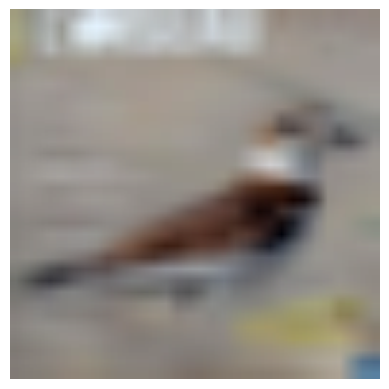

In [6]:
classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer','Dog', 'Frog', 'Horse', 'Ship', 'Truck']

def plot_figure(image):
    plt.imshow(image.permute(1,2,0))
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(test_loader))
print(f'La imagen muestreada representa un: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
plot_figure(image)

### Calculate the Accuracy

In [7]:
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in loader:
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            _, pred = scores.max(dim=1) #pred shape (mb_size )
            num_correct += (pred == yi).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)
        return float(num_correct)/num_total   



### Load the model

In this step we'll loading the model using the function torchvision

In [9]:
from torchvision.models import ResNet18_Weights

model_resnet18 = models.resnet18(weights=ResNet18_Weights.DEFAULT)

#### Checking the model's results

In [10]:
for i, w in enumerate(model_resnet18.parameters()):
    print(i, w.shape, w.requires_grad)

0 torch.Size([64, 3, 7, 7]) True
1 torch.Size([64]) True
2 torch.Size([64]) True
3 torch.Size([64, 64, 3, 3]) True
4 torch.Size([64]) True
5 torch.Size([64]) True
6 torch.Size([64, 64, 3, 3]) True
7 torch.Size([64]) True
8 torch.Size([64]) True
9 torch.Size([64, 64, 3, 3]) True
10 torch.Size([64]) True
11 torch.Size([64]) True
12 torch.Size([64, 64, 3, 3]) True
13 torch.Size([64]) True
14 torch.Size([64]) True
15 torch.Size([128, 64, 3, 3]) True
16 torch.Size([128]) True
17 torch.Size([128]) True
18 torch.Size([128, 128, 3, 3]) True
19 torch.Size([128]) True
20 torch.Size([128]) True
21 torch.Size([128, 64, 1, 1]) True
22 torch.Size([128]) True
23 torch.Size([128]) True
24 torch.Size([128, 128, 3, 3]) True
25 torch.Size([128]) True
26 torch.Size([128]) True
27 torch.Size([128, 128, 3, 3]) True
28 torch.Size([128]) True
29 torch.Size([128]) True
30 torch.Size([256, 128, 3, 3]) True
31 torch.Size([256]) True
32 torch.Size([256]) True
33 torch.Size([256, 256, 3, 3]) True
34 torch.Size([25

### Checking the model resnet18

In [11]:
model_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Modify the model

At this step we are creating a sequential duplicate of the resnet18 model.

In [12]:
model_aux = nn.Sequential(*list(model_resnet18.children()))
model_aux

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

At this step we remove the last linear layer on the model so we can replace it later with a linear layer that is compatible with the number of features in our use case.

In [13]:
model_aux = nn.Sequential(*list(model_resnet18.children())[:-1])

In [14]:
model_aux

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

There we're show each the parameters from model aux

In [15]:
for i, parameter in enumerate(model_aux.parameters()):
    parameter.requires_grad = False

In [16]:
for i, parameter in enumerate(model_aux.parameters()):
    print(i, parameter.requires_grad)

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 False
33 False
34 False
35 False
36 False
37 False
38 False
39 False
40 False
41 False
42 False
43 False
44 False
45 False
46 False
47 False
48 False
49 False
50 False
51 False
52 False
53 False
54 False
55 False
56 False
57 False
58 False
59 False


### Loop de entrenamiento

In [17]:
def train(model, optimiser, epochs=100):
#     def train(model, optimiser, scheduler = None, epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
        for i, (xi, yi) in enumerate(train_loader):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)

            cost = F.cross_entropy(input= scores, target=yi)
        
            optimiser.zero_grad()           
            cost.backward()
            optimiser.step()           
            
        acc = accuracy(model, val_loader)
#         if epoch%5 == 0:     
        print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy: {acc},')
#         scheduler.step()

In this step we're trainng the model

In [18]:
hidden1 = 256 
hidden = 256
lr = 5e-4
epochs = 3
# model1 = nn.Sequential(nn.Flatten(),
#                        nn.Linear(in_features=32*32*3, out_features=hidden1), nn.ReLU(),
#                        nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
#                        nn.Linear(in_features=hidden, out_features=10))

model1 = nn.Sequential(model_aux,
                       nn.Flatten(), 
                       nn.Linear(in_features=512, out_features= 10, bias= True))
optimiser = torch.optim.Adam(model1.parameters(), lr=lr, betas=(0.9, 0.999))

# train(model1, optimiser, epochs)

In [20]:
train(model1, optimiser, epochs)

Epoch: 0, costo: 0.5979734659194946, accuracy: 0.7758,
Epoch: 1, costo: 0.6439229249954224, accuracy: 0.7936,
Epoch: 2, costo: 0.8765835165977478, accuracy: 0.793,


In this step we're checking the accurancy from the trainng

In [23]:
accuracy(model1, test_loader)

0.7922

# AlexNet Model

The first model we decided to apply learning transfer is on AlexNet. This model is based on an architecture that contains a total of 5 convolutional networks and 3 fully connected layers.

![AlexNet architecture](https://miro.medium.com/v2/resize:fit:960/0*pJ3o_2zTTNnixhKH.png)

First we download the pretrained model with the default weights

In [21]:
model_alexnet = models.alexnet(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /Users/alexhahn/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
10.1%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

30.8%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

51.9%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Notebo

In [22]:
model_alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

We take the model as-is, we just remove the last linear layer in order to replace it with a linear layer consistent with the number of classes at this use case

In [24]:
model_alexnet_aux = nn.Sequential(*list(model_alexnet.children())[:-1])

We're apply the optimization with the function optim from torch library

In [29]:
lr = 5e-4
epochs = 3

model_alexnet_tr = nn.Sequential(
    model_alexnet_aux,
    nn.Flatten(),
    nn.Linear(in_features=9216, out_features= 10, bias= True)
)

optimiser = torch.optim.Adam(model_alexnet_tr.parameters(), lr=lr, betas=(0.9, 0.999))

In this step we're trainng the model

In [30]:
train(model_alexnet_tr, optimiser, epochs)

Epoch: 0, costo: 0.29462677240371704, accuracy: 0.7962,
Epoch: 1, costo: 0.5230237245559692, accuracy: 0.8532,
Epoch: 2, costo: 0.011343254707753658, accuracy: 0.8436,


We obtain a accuracy of 83.69% using AlexNet, this is a better performance than ResNet

In [31]:
accuracy(model_alexnet_tr, test_loader)

0.8369

# GoogLeNet

The second model we decided to use is GoogLeNet, a model based on the Inception architecture and that uses a total of 19 layers that cover convolution, max pooling, linear and inception.

At first we download the model with the default weights

In [32]:
model_googlenet = models.googlenet(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /Users/alexhahn/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
47.1%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0%


In [33]:
model_googlenet

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In this step we modify the model GoogLeNet excluding the last linear layer so we can replace it with a layer compatible with the number of classes in the use case

In [34]:
model_googlenet_aux = nn.Sequential(*list(model_googlenet.children())[:-1])

We're apply the optimization with the function optim from torch library

In [35]:
lr = 5e-4
epochs = 3

model_googlenet_tr = nn.Sequential(
    model_googlenet_aux,
    nn.Flatten(),
    nn.Linear(in_features=1024, out_features= 10, bias= True)
)

optimiser = torch.optim.Adam(model_googlenet_tr.parameters(), lr=lr, betas=(0.9, 0.999))

In this step we're trainng the model

In [36]:
train(model_googlenet_tr, optimiser, epochs)

Epoch: 0, costo: 0.08943908661603928, accuracy: 0.9192,
Epoch: 1, costo: 0.47525444626808167, accuracy: 0.918,
Epoch: 2, costo: 0.006916591431945562, accuracy: 0.9274,


We obtained a accuracy of 91.8%, this beats the performance of both ResNet and AlexNet by ~8%

In [39]:
accuracy(model_googlenet_tr, test_loader)

0.918